<a href="https://colab.research.google.com/github/phantasticphenomenon/Hello-World/blob/master/DengAI_PredictingDiseaseSpread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem description

The goal is to predict the total_cases label for each (city, year, weekofyear) in the test set.
* There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. 
* You will make one submission that contains predictions for both cities. 
* The data for each city have been concatenated along with a city column indicating the source: sj for San Juan and iq for Iquitos. 
* The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. 
* Throughout, missing values have been filled as NaNs.


## The features in this dataset

You are provided the following set of information on a (year, weekofyear) timescale:

(Where appropriate, units are provided as a _unit suffix on the feature name.)

### City and date indicators
* city – City abbreviations: sj for San Juan and  iq for Iquitos
* week_start_date – Date given in yyyy-mm-dd format
### NOAA's GHCN daily climate data weather station measurements
* station_max_temp_c – Maximum temperature
* station_min_temp_c – Minimum temperature
*station_avg_temp_c – Average temperature
* station_precip_mm – Total precipitation
* station_diur_temp_rng_c – Diurnal temperature range
### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
* precipitation_amt_mm – Total precipitation
### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
* reanalysis_sat_precip_amt_mm – Total precipitation
* reanalysis_dew_point_temp_k – Mean dew point temperature
* reanalysis_air_temp_k – Mean air temperature
* reanalysis_relative_humidity_percent – Mean relative humidity
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity
* reanalysis_precip_amt_kg_per_m2 – Total precipitation
* reanalysis_max_air_temp_k – Maximum air temperature
* reanalysis_min_air_temp_k – Minimum air temperature
* reanalysis_avg_temp_k – Average air temperature
* reanalysis_tdtr_k – Diurnal temperature range
### Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
* ndvi_se – Pixel southeast of city centroid
* ndvi_sw – Pixel southwest of city centroid
* ndvi_ne – Pixel northeast of city centroid
* ndvi_nw – Pixel northwest of city centroid

# **1. Import Libraries**

In [0]:
#Import numpy and pandas libraries for dataframe and array manipulation
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import fileinput
from google.colab import files

# Import libraries
from scipy import stats

# import sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error




In [109]:
# Mount gdrive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **2. Get the data**

In [0]:

# Define the location of the input data
X_train_filePath ="/content/gdrive/My Drive/DataScience/3253_Project/dengue_features_train.csv"
y_train_filePath ="/content/gdrive/My Drive/DataScience/3253_Project/dengue_labels_train.csv"
X_test_filePath ="/content/gdrive/My Drive/DataScience/3253_Project/dengue_features_test.csv"
#y_test_filePath ="/content/gdrive/My Drive/DataScience/3253_Project/dengue_labels_test.csv"

# Read data into pandas
X_train = pd.read_csv(X_train_filePath, sep=",")
y_train = pd.read_csv(y_train_filePath, sep=",")

X_test = pd.read_csv(X_test_filePath, sep=",")
#y_test = pd.read_csv(y_test_filePath, sep=",", index_col=0)


# **3. Overview of the data**

In [111]:
# Check the features shape
X_train.shape

(1456, 24)

In [112]:
# Check the features shape
y_train.shape

(1456, 4)

In [113]:
# Overview of the data
X_train.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


In [114]:
# The feature attributes
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

**Summary**



# **4. Exploratory Data Analysis**

In [0]:
# Merge the features data and the labels data
df = X_train.merge(y_train, how='inner', left_on=['city', 'year', 'weekofyear'], right_on=['city', 'year', 'weekofyear'])
df = df.sort_values(['city', 'year', 'weekofyear'])

In [116]:
#Check the size of the samples for each city
print(df[df['city'] == 'sj'].shape)
print(df[df['city'] == 'iq'].shape)

(936, 25)
(520, 25)


**The cities have different  size samples , so stratified sampling is used**

In [0]:
# Split the data into train and validation using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["city"]):
    df_train = df.loc[train_index]
    df_val = df.loc[test_index]

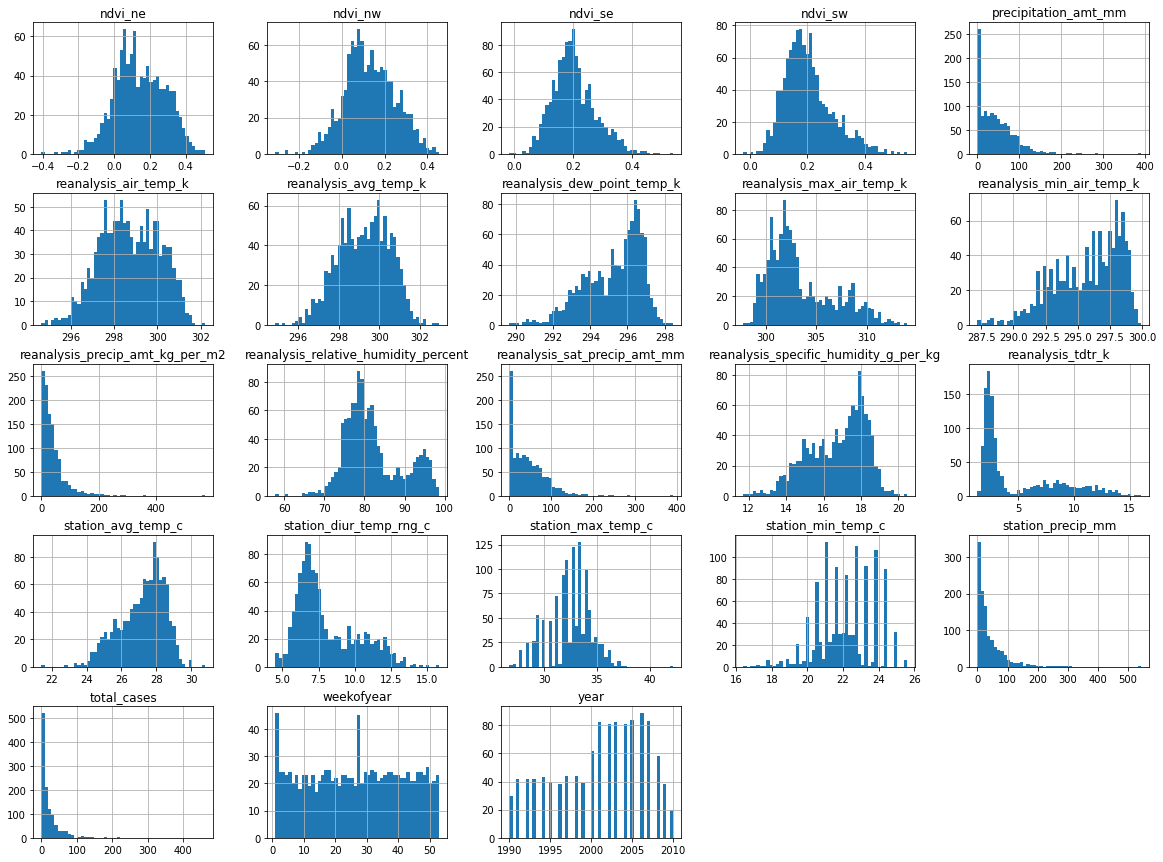

Text(0.5, 0.98, 'figure title')

<Figure size 432x288 with 0 Axes>

In [118]:
# Visualise the data
df_train.hist(bins=50, figsize=(20,15))
plt.show()
plt.suptitle('figure title', color='w')

**Splitting the data by city and cleaning it**

In [0]:
def df_split(x):
  x_sj = x[x['city'] == 'sj'].sort_values(['city', 'year', 'weekofyear'])
  x_iq = x[x['city'] == 'iq'].sort_values(['city', 'year', 'weekofyear'])
  return x_sj, x_iq

In [0]:
df_sj,df_iq = df_split(df_train)

In [121]:
# Check for missing values in San juan dataand deciding on how to deal with them
df_sj.isna().sum() 

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  155
ndvi_nw                                   38
ndvi_se                                   16
ndvi_sw                                   16
precipitation_amt_mm                       7
reanalysis_air_temp_k                      4
reanalysis_avg_temp_k                      4
reanalysis_dew_point_temp_k                4
reanalysis_max_air_temp_k                  4
reanalysis_min_air_temp_k                  4
reanalysis_precip_amt_kg_per_m2            4
reanalysis_relative_humidity_percent       4
reanalysis_sat_precip_amt_mm               7
reanalysis_specific_humidity_g_per_kg      4
reanalysis_tdtr_k                          4
station_avg_temp_c                         4
station_diur_temp_rng_c                    4
station_max_temp_c                         4
station_mi

In [122]:
# Check for missing values in Iquitp data and deciding on how to deal with them
df_iq.isna().sum() 

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                   2
ndvi_nw                                   2
ndvi_se                                   2
ndvi_sw                                   2
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       34
station_diur_temp_rng_c                  34
station_max_temp_c                       12
station_min_temp_c              

* There are more missing values from in station_avg_temp_c, station_diur_temp_rng_c, station_max_temp_c, station_min_temp_c, station_precip_mm, which is the temperature data.
* The missing values for temperatures will be imputed with ffill as temperature 
* We use front fill, which uses the prior observation to impute, and this will work well for temperature is it normally circle around the same range of values.

In [0]:
df_sj = df_sj.fillna(df_sj.median())
df_iq = df_iq.fillna(method = 'ffill')

In [0]:
# function to plot the graphs
def plot_city(df_city,city):
    df_city['total_cases'].plot(figsize = (15,5))
    plt.title(str(city))
    plt.xlabel("Year, Week of Year")
    plt.ylabel("Number of Cases")

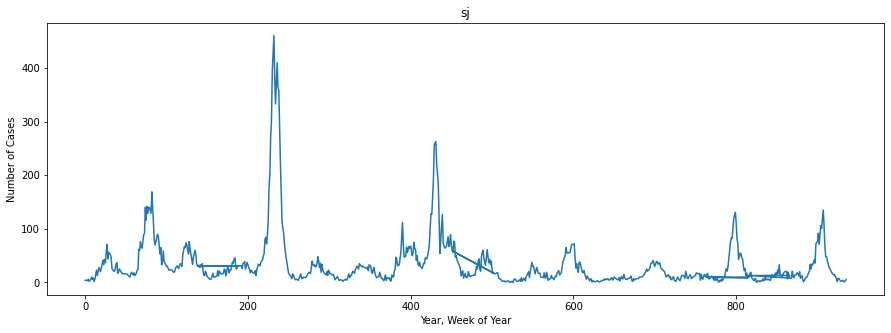

In [125]:
plot_city(df_sj,'sj')


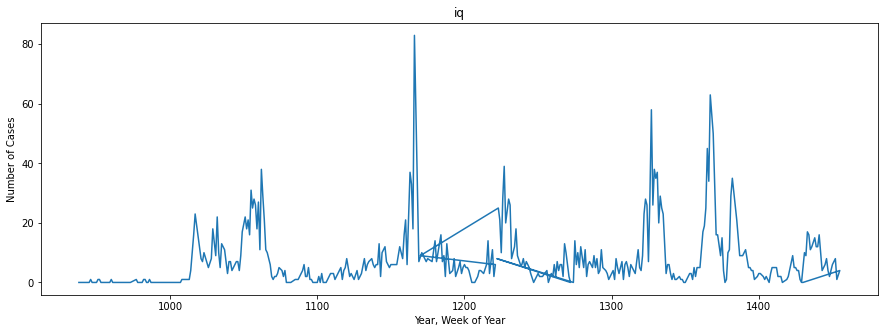

In [126]:
plot_city(df_iq,'iq')

* There are some spikes in the data for both cities. 
* The spikes will be treated as outliers and will be reduced so that the data has a cyclic trend, which will be much better at predicting the spread.
* The spikes are pandemic cases which is not a cyclic thing.


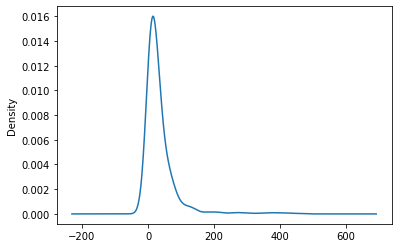

In [127]:
ax_sj = df_sj['total_cases'].plot.kde(bw_method=0.3)

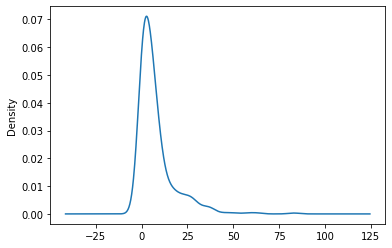

In [128]:
ax_iq = df_iq['total_cases'].plot.kde(bw_method=0.3)

* Th z-score will be used to identify the outliers or pandemics
* z-score is used as the number of total cases data follows a normal distribution

In [0]:
# Using the z-score to identify outliers.

z_sj = np.abs(stats.zscore(df_sj['total_cases']))
#print(z_sj)

In [0]:
z_iq = np.abs(stats.zscore(df_iq['total_cases']))
#print(z_iq)

In [131]:
# Setting threshold to identifying data points above that
threshold = 2
print(np.where(z_sj > threshold))
print(np.where(z_iq > threshold))

(array([ 62,  67, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 346, 347, 348, 349, 350, 351]),)
(array([ 93,  95, 100, 101, 186, 187, 189, 190, 234, 235, 238, 314, 317,
       318, 320, 321, 322, 324, 351, 352, 353, 354, 364, 365]),)


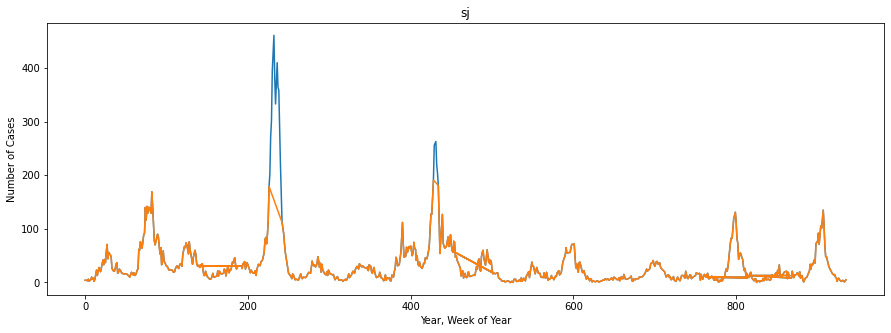

In [132]:
# Setting the threshold to 3 for city of San Juan and ploting the graphs showing the transformation
sj_t = df_sj[(z_sj < 3)]
plot_city(df_sj,'sj')
plot_city(sj_t,'sj')

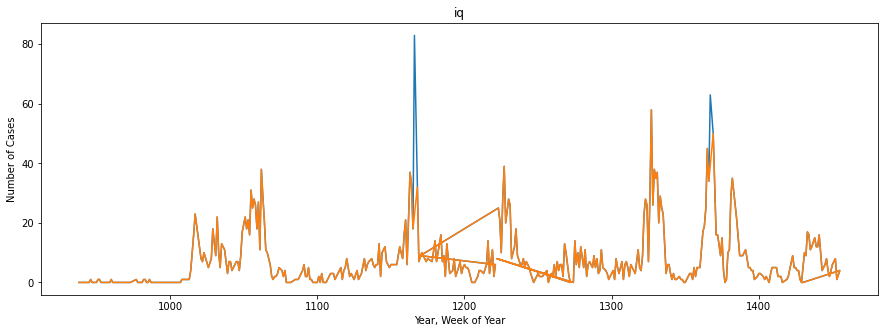

In [133]:
# Setting the threshold to 3 for city of Iquitos and ploting the graphs showing the transformation
iq_t = df_iq[(z_iq < 5)]
plot_city(df_iq,'iq')
plot_city(iq_t,'iq')

** The graphs now look more normalised **

# **Prepare the Data for ML algorithms**

In [0]:
# Define columns to drop
columns_drop = ["week_start_date","weekofyear","year","reanalysis_air_temp_k"]

In [0]:
def get_train_test(df1,df2):
  df = pd.concat([df1, df2])
  X = df.drop(["total_cases"], axis=1)
  y = df["total_cases"]
  return X,y

In [0]:
X_train, y_train = get_train_test(sj_t,iq_t)


In [0]:

# apply le on categorical feature columns
def encode_cat(x):
  # import labelencoder
  from sklearn.preprocessing import LabelEncoder

  # Identify categorical columns
  categorical_feature_mask = x.dtypes==object
  # filter categorical columns using mask and turn it into a list
  categorical_cols = x.columns[categorical_feature_mask].tolist()
  
  # instantiate labelencoder object
  le = LabelEncoder()
  #Apply the label encoder to the data
  x[categorical_cols] = x[categorical_cols].apply(lambda col: le.fit_transform(col))
  return x

In [0]:
X_train_num = encode_cat(X_train)


In [0]:
# Drop the columns
X_train_tr = X_train_num.drop(columns_drop, axis=1)


In [0]:
#Pipeline for scaling data
num_pipeline = Pipeline([                       
                         ('std_scaler', StandardScaler()),
])
X_train_tr = num_pipeline.fit_transform(X_train_tr)

In [0]:
#

In [0]:
# Process the validation data
X_val_sj,X_val_iq = df_split(df_val)
X_val_sj = X_val_sj.fillna(df_sj.median())
X_val_iq = X_val_iq.fillna(method = 'ffill')
X_val_num, y_val = get_train_test(X_val_sj,X_val_iq)
X_val_num = encode_cat(X_val_num)
X_val_tr = X_val_num.drop(columns_drop, axis=1)
X_val_tr = num_pipeline.fit_transform(X_val_tr)


In [0]:
# Process the test data
X_test_sj,X_test_iq = df_split(X_test)
X_test_sj = X_test_sj.fillna(df_sj.median())
X_test_iq = X_test_iq.fillna(method = 'ffill')
X_test_num = pd.concat([X_test_sj, X_test_iq])
X_test_num = encode_cat(X_test_num)
X_test_tr = X_test_num.drop(columns_drop, axis=1)
X_test_tr = num_pipeline.fit_transform(X_test_tr)

In [231]:
X_train_tr.shape

(1145, 20)

In [232]:
X_val_tr.shape

(292, 20)

In [233]:
X_test_tr.shape


(416, 20)

In [234]:
y_val.shape

(292,)

# **Select and Train a model**

In [0]:

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

In [0]:
models=[LinearRegression(),Lasso(alpha=.5),KNeighborsRegressor(),GaussianNB(),
        SVR(kernel='rbf'),GradientBoostingRegressor(),RandomForestRegressor(),SGDRegressor(max_iter=1000, tol=1e-3) ]

In [184]:
for model in models:
  scores = cross_val_score(model, X_train_tr, y_train, 
                         scoring = "neg_mean_absolute_error", cv=5)
  print("*******************************\n\n")
  print(model)
  display_scores(-scores)

  

*******************************


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Scores: [22.55492956 21.77399518 25.17171156 10.69799925  9.05204756]
Mean: 17.850136621994277
Standard deviation: 6.628674713623902
*******************************


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Scores: [22.17167685 21.45818827 24.07924542 10.0002139   7.93237422]
Mean: 17.12833972956241
Standard deviation: 6.750909377121512
*******************************


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
Scores: [26.09868996 25.60611354 25.75982533 10.21484716  6.61222707]
Mean: 18.858340611353714
Standard deviation: 8.605380469947326
*******************************


Gauss

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


*******************************


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Scores: [25.99433417 21.16562355 15.74084902  9.1649238   6.12967188]
Mean: 15.639080484016224
Standard deviation: 7.350209125473465
*******************************


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, wa

* SVR has the best MAE score of 15.639080484016224
* Lasso has the second best MAE of 17.028630102354043

# **Optimizing the model**
* The 2 best model chosen for hyperparameter tuning 


In [0]:
def get_model_improvement(scores1,scores2):
   return 100*((scores1- scores2)/scores1) 
  

# SVR

In [186]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)

grid_search.fit(X_train_tr, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.001, 0.0001], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=0)

In [187]:
 grid_search.best_estimator_

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
scores = cross_val_score(grid_search.best_estimator_, X_train_tr, y_train, 
                         scoring = "neg_mean_absolute_error", cv=5)

In [189]:
display_scores(scores)

Scores: [-26.26131663 -21.49493654 -14.73992463  -9.59988778  -6.05723494]
Mean: -15.630660105671208
Standard deviation: 7.432559318657194


In [0]:
cvres = grid_search.cv_results_

# Lasso

In [193]:
param_grid = [
  {'alpha': [0.1, 0.4, 0.6, 0.9], 'max_iter': [10000, 100000], 'tol':[0.0001,0.000001]},
  {'alpha': [0.1, 0.3, 0.5, 0.8], 'max_iter': [15000,50000], 'tol':[0.0001,0.000001]},
 ]

lasso = Lasso()
grid_search_lasso = GridSearchCV(lasso, param_grid, cv=5,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)

grid_search_lasso.fit(X_train_tr, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.1, 0.4, 0.6, 0.9],
                          'max_iter': [10000, 100000], 'tol': [0.0001, 1e-06]},
                         {'alpha': [0.1, 0.3, 0.5, 0.8],
                          'max_iter': [15000, 50000], 'tol': [0.0001, 1e-06]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=0)

In [0]:
lasso_scores = cross_val_score(grid_search_lasso.best_estimator_, X_train_tr, y_train, 
                         scoring = "neg_mean_absolute_error", cv=5)

In [195]:
display_scores(-lasso_scores)

Scores: [22.00604527 21.06128662 23.51497751 10.37727335  8.2728073 ]
Mean: 17.04647800960256
Standard deviation: 6.387692383309894


In [196]:
lasso_improvement = get_model_improvement(17.12833972956241,17.04647800960256)
svc_improvement = get_model_improvement(15.639080484016224,15.630660105671208)
print('lasso Improvement: {:2.2}%'.format(lasso_improvement))
print('SVC Improvement: {:2.2}%'.format(svc_improvement))

lasso Improvement: 0.48%
SVC Improvement: 0.054%


# **Validating the models using the validation set** 

In [235]:
# SVC Validation
final_model_svr = grid_search.best_estimator_
final_predictions = final_model_svr.predict(X_val_tr)
final_mae = mean_absolute_error(y_val, final_predictions)
print('svc mae: {:2}'.format(final_mae))

svc mae: 15.400543846821773


**SVC performs OK on the validation data, with a mae score of 15.4 compared to 15.6 on the train data**

# **Submision**

In [0]:
#cvres = grid_search.cv_results_
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#  print(np.sqrt(-mean_score), params)

In [0]:
final_model_svr = grid_search.best_estimator_
final_predictions = final_model_svr.predict(X_test_tr)
final_predictions = np.round(final_predictions,decimals=0)

In [0]:
submission = X_test[["city", "year","weekofyear"]]

submission.insert(3,'total_cases',final_predictions)

submission.to_csv('submission_format.csv', index=False)

submission = pd.read_csv('submission_format.csv')
files.download('submission_format.csv')

# **Summary and Conclusions**